# Set Up Feature Store

## Import libraries

In [1]:
import boto3
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import sagemaker
import seaborn as sns
import time
import warnings

from IPython.core.display import HTML
from pandas.api.types import CategoricalDtype
from pyathena import connect
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.session import Session
from sklearn.impute import SimpleImputer
import awswrangler as wr

# suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# filter out the specific UserWarning related to DBAPI2 objects
warnings.filterwarnings('ignore', message="pandas only supports SQLAlchemy connectable")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
# check stored variables
%store

Stored variables and their in-db values:
bucket_name                            -> 'housing-dataset-5435xx'
set_up_dependencies_passed             -> True
set_up_s3_bucket_passed                -> True


## Pull Data from Athena

In [3]:
# save Amazon information
account_id = boto3.client("sts").get_caller_identity().get("Account")
region = boto3.Session().region_name
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
s3 = boto3.client('s3', region_name=sagemaker_session.boto_region_name)

In [4]:
# get bucket_name
%store -r bucket_name
print(bucket_name)

# set S3 staging directory
s3_staging_dir = "s3://{0}/athena/staging".format(bucket_name)

# create connection
# using AWS Wrangler to create the Feature Store and Feature Group
#conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

housing-dataset-5435xx


In [5]:
# set database name and table name
database_name = "housing"
table_name = "data"

# set database name and table name
database_name = "housing"
table_name = "data"

# pull data
statement = """SELECT * FROM {}.{}""".format(
    database_name, table_name
)

# pull data using AWS Wrangler
df = wr.athena.read_sql_query(
    sql=statement,
    database=database_name,
    ctas_approach=False,
    boto3_session=boto3.Session(),
)
df.head(5)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,<NA>,Reg,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,<NA>,Reg,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,<NA>,IR1,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,<NA>,IR1,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,<NA>,IR1,Lvl,AllPub,...,0,<NA>,<NA>,<NA>,0,12,2008,WD,Normal,250000.0


## Feature Engineering

In [6]:
# drop numerical feature with a lot of missing values
df = df.drop('lotfrontage', axis=1)

# drop categorical features with a lot of missing values
df = df.drop('fireplacequ', axis=1)
df = df.drop('fence', axis=1)
df = df.drop('alley', axis=1)
df = df.drop('miscfeature', axis=1)
df = df.drop('poolqc', axis=1)

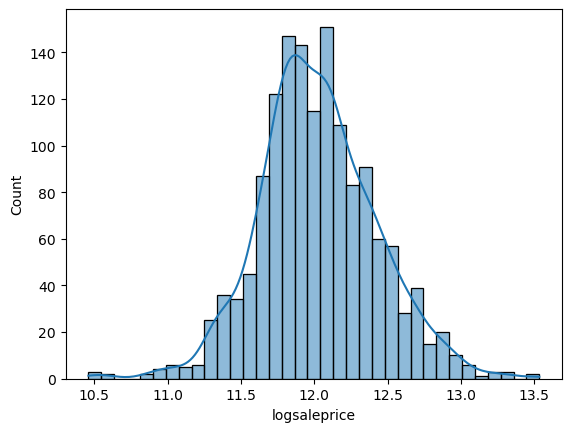

In [7]:
# apply log transformation
df['logsaleprice'] = np.log(df['saleprice'])

# plot histogram to see the new distribution
sns.histplot(df['logsaleprice'], kde=True)
plt.show()

In [8]:
# the ordinal (ordered) categorical features
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))
ordered_levels = {
    "overallqual": ten_levels,
    "overallcond": ten_levels,
    "exterqual": five_levels,
    "extercond": five_levels,
    "bsmtqual": five_levels,
    "bsmtcond": five_levels,
    "heatingqc": five_levels,
    "kitchenqual": five_levels,
    "garagequal": five_levels,
    "garagecond": five_levels,
    "lotshape": ["Reg", "IR1", "IR2", "IR3"],
    "landslope": ["Sev", "Mod", "Gtl"],
    "bsmtexposure": ["No", "Mn", "Av", "Gd"],
    "bsmtfintype1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "bsmtfintype2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "garagefinish": ["Unf", "RFn", "Fin"],
    "paveddrive": ["N", "P", "Y"],
    "utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "centralair": ["N", "Y"],
    "electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"]
}

# define ordered categorical data
for name, levels in ordered_levels.items():
    df[name] = df[name].astype(CategoricalDtype(levels, ordered=True))

# assign the code to the categories
for name in ordered_levels.keys():
    df[name] = df[name].cat.codes

In [9]:
# the nominal categorical features
features_nom = ["mssubclass", "mszoning", "street", "landcontour",
                "lotconfig", "neighborhood", "condition1", "condition2",
                "bldgtype", "housestyle", "roofstyle", "roofmatl", "exterior1st",
                "exterior2nd", "masvnrtype", "foundation", "heating", "centralair",
                "garagetype", "saletype", "salecondition"]

# function to one hot encode categorical columns
def one_hot_encode_categorical_columns(df):
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    df_encoded = pd.get_dummies(df, columns=categorical_columns)
    return df_encoded

# perform the one-hot encode on categorical  columns
df_encoded = one_hot_encode_categorical_columns(df)

print(df_encoded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2919 non-null   Int32  
 1   mssubclass     2919 non-null   Int32  
 2   mszoning       2915 non-null   string 
 3   lotarea        2919 non-null   Int32  
 4   street         2919 non-null   string 
 5   lotshape       2919 non-null   int8   
 6   landcontour    2919 non-null   string 
 7   utilities      2919 non-null   int8   
 8   lotconfig      2919 non-null   string 
 9   landslope      2919 non-null   int8   
 10  neighborhood   2919 non-null   string 
 11  condition1     2919 non-null   string 
 12  condition2     2919 non-null   string 
 13  bldgtype       2919 non-null   string 
 14  housestyle     2919 non-null   string 
 15  overallqual    2919 non-null   int8   
 16  overallcond    2919 non-null   int8   
 17  yearbuilt      2919 non-null   Int32  
 18  yearremo

In [10]:
# Convert uint8 columns to integer type
uint8_columns = df_encoded.select_dtypes(include=['uint8']).columns.tolist()
df_encoded[uint8_columns] = df_encoded[uint8_columns].astype(int)

print(df_encoded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2919 non-null   Int32  
 1   mssubclass     2919 non-null   Int32  
 2   mszoning       2915 non-null   string 
 3   lotarea        2919 non-null   Int32  
 4   street         2919 non-null   string 
 5   lotshape       2919 non-null   int8   
 6   landcontour    2919 non-null   string 
 7   utilities      2919 non-null   int8   
 8   lotconfig      2919 non-null   string 
 9   landslope      2919 non-null   int8   
 10  neighborhood   2919 non-null   string 
 11  condition1     2919 non-null   string 
 12  condition2     2919 non-null   string 
 13  bldgtype       2919 non-null   string 
 14  housestyle     2919 non-null   string 
 15  overallqual    2919 non-null   int8   
 16  overallcond    2919 non-null   int8   
 17  yearbuilt      2919 non-null   Int32  
 18  yearremo

In [11]:
# impute missing values for numerical columns with median
numerical_columns = df_encoded.select_dtypes(include=['int32', 'float32']).columns.tolist()
numerical_imputer = SimpleImputer(strategy='median')
df_numerical_imputed = pd.DataFrame(numerical_imputer.fit_transform(df_encoded[numerical_columns]), columns=numerical_columns)

# create new imputed dataset
df_imputed = pd.concat([df_numerical_imputed], axis=1)
shape = df_imputed.shape
print("Shape of the dataframe (row, col):",shape,"\r\n")
df_imputed.head(5)

Shape of the dataframe (row, col): (2919, 36) 



,id,mssubclass,lotarea,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,...,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice,logsaleprice
0,1.0,60.0,8450.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,...,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0,12.247694
1,2.0,20.0,9600.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0,12.109011
2,3.0,60.0,11250.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,...,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0,12.317166
3,4.0,70.0,9550.0,1915.0,1970.0,0.0,216.0,0.0,540.0,756.0,...,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0,11.849398
4,5.0,60.0,14260.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,...,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0,12.429216


## Prepare Data for Feature Store

In [12]:
# add an event time
df_imputed['event_time'] = pd.Timestamp.now()
df_imputed.head(5)

,id,mssubclass,lotarea,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,...,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice,logsaleprice,event_time
0,1.0,60.0,8450.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,...,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0,12.247694,2024-06-19 05:28:35.948162
1,2.0,20.0,9600.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,...,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0,12.109011,2024-06-19 05:28:35.948162
2,3.0,60.0,11250.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,...,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0,12.317166,2024-06-19 05:28:35.948162
3,4.0,70.0,9550.0,1915.0,1970.0,0.0,216.0,0.0,540.0,756.0,...,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0,11.849398,2024-06-19 05:28:35.948162
4,5.0,60.0,14260.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,...,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0,12.429216,2024-06-19 05:28:35.948162


In [13]:
# check column types
print(df_imputed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             2919 non-null   float64       
 1   mssubclass     2919 non-null   float64       
 2   lotarea        2919 non-null   float64       
 3   yearbuilt      2919 non-null   float64       
 4   yearremodadd   2919 non-null   float64       
 5   masvnrarea     2919 non-null   float64       
 6   bsmtfinsf1     2919 non-null   float64       
 7   bsmtfinsf2     2919 non-null   float64       
 8   bsmtunfsf      2919 non-null   float64       
 9   totalbsmtsf    2919 non-null   float64       
 10  firstflrsf     2919 non-null   float64       
 11  secondflrsf    2919 non-null   float64       
 12  lowqualfinsf   2919 non-null   float64       
 13  grlivarea      2919 non-null   float64       
 14  bsmtfullbath   2919 non-null   float64       
 15  bsmthalfbath   2919 n

In [14]:
is_saleprice_in_imputed = 'saleprice' in df_imputed.columns
print(f"'saleprice' in df_imputed: {is_saleprice_in_imputed}")

'saleprice' in df_imputed: True


In [15]:
# convert datetime to Unix timestamp (seconds since epoch)
df_imputed['event_time'] = df_imputed['event_time'].astype(int) / 10**9

In [16]:
# function to clean column names for feature store
def clean_feature_name(feature_name):
    # Replace invalid characters with underscores
    cleaned_name = re.sub(r'[^a-zA-Z0-9_-]', '_', feature_name)
    # Ensure the name does not start or end with an underscore or hyphen
    cleaned_name = re.sub(r'^[_-]+|[_-]+$', '', cleaned_name)
    return cleaned_name

# Apply the cleaning function to the column names
cleaned_columns = [clean_feature_name(col) for col in df_imputed.columns]
df_imputed.columns = cleaned_columns

## Set Up Feature Store

In [17]:
# define feature group names for train, validation, and test
train_feature_group_name = "housing_train"
validation_feature_group_name = "housing_validation"
test_feature_group_name = "housing_test"

In [18]:
# split the data into train, validation, and test sets
train_data, validation_data, test_data = np.split(df_imputed.sample(frac=1, random_state=42), [int(0.7*len(df_imputed)), int(0.9*len(df_imputed))])

In [19]:
# record identifier and event time feature names
record_identifier_feature_name = "id"
event_time_feature_name = "event_time"    
prefix = "feature_store"

In [20]:
# set up Feature Store Session with AWS
boto_session = boto3.Session(region_name=region)
sagemaker_client = boto_session.client(service_name="sagemaker", region_name=region)
featurestore_runtime = boto_session.client(
    service_name="sagemaker-featurestore-runtime", region_name=region
)
feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime,
)

In [21]:
housing_train_feature_group = FeatureGroup(name=train_feature_group_name, sagemaker_session=feature_store_session)

In [22]:
housing_validation_feature_group = FeatureGroup(name=validation_feature_group_name, sagemaker_session=feature_store_session)

In [23]:
housing_test_feature_group = FeatureGroup(name=test_feature_group_name, sagemaker_session=sagemaker_session)

In [24]:
# load feature definitions to the feature group
housing_train_feature_group.load_feature_definitions(data_frame=train_data)

[FeatureDefinition(feature_name='id', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='mssubclass', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='lotarea', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='yearbuilt', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='yearremodadd', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='masvnrarea', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='bsmtfinsf1', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='bsmtfinsf2', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 F

In [25]:
# load feature definitions to the feature group
housing_validation_feature_group.load_feature_definitions(data_frame=validation_data)

[FeatureDefinition(feature_name='id', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='mssubclass', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='lotarea', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='yearbuilt', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='yearremodadd', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='masvnrarea', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='bsmtfinsf1', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='bsmtfinsf2', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 F

In [26]:
# load feature definitions to the feature group
housing_test_feature_group.load_feature_definitions(data_frame=test_data)

[FeatureDefinition(feature_name='id', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='mssubclass', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='lotarea', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='yearbuilt', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='yearremodadd', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='masvnrarea', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='bsmtfinsf1', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='bsmtfinsf2', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 F

In [27]:
# create feature groups in feature store
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")

In [28]:
# Function to delete feature group if it exists
def delete_feature_group_if_exists(feature_group_name):
    try:
        response = sagemaker_client.describe_feature_group(FeatureGroupName=feature_group_name)
        if response['FeatureGroupStatus'] in ['Created', 'CreateFailed', 'CreatePending']:
            print(f"FeatureGroup {feature_group_name} exists. Deleting it...")
            sagemaker_client.delete_feature_group(FeatureGroupName=feature_group_name)
            wait_for_feature_group_deletion(feature_group_name)
    except sagemaker_client.exceptions.ResourceNotFound:
        print(f"FeatureGroup {feature_group_name} does not exist. No need to delete.")


def wait_for_feature_group_deletion(feature_group_name):
    while True:
        try:
            response = sagemaker_client.describe_feature_group(FeatureGroupName=feature_group_name)
            print("Waiting for Feature Group Deletion")
            time.sleep(5)
        except sagemaker_client.exceptions.ResourceNotFound:
            print(f"FeatureGroup {feature_group_name} successfully deleted.")
            break

# Delete the feature groups if they exist
delete_feature_group_if_exists(train_feature_group_name)
delete_feature_group_if_exists(validation_feature_group_name)
delete_feature_group_if_exists(test_feature_group_name)

FeatureGroup housing_train exists. Deleting it...
Waiting for Feature Group Deletion
FeatureGroup housing_train successfully deleted.
FeatureGroup housing_validation exists. Deleting it...
Waiting for Feature Group Deletion
FeatureGroup housing_validation successfully deleted.
FeatureGroup housing_test exists. Deleting it...
Waiting for Feature Group Deletion
FeatureGroup housing_test successfully deleted.


In [29]:
housing_train_feature_group.create(
    s3_uri=f"s3://{bucket_name}/{prefix}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True,
)

wait_for_feature_group_creation_complete(feature_group=housing_train_feature_group)

Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup housing_train successfully created.


In [30]:
housing_validation_feature_group.create(
    s3_uri=f"s3://{bucket_name}/{prefix}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True,
)

wait_for_feature_group_creation_complete(feature_group=housing_validation_feature_group)

Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup housing_validation successfully created.


In [31]:
housing_test_feature_group.create(
    s3_uri=f"s3://{bucket_name}/{prefix}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True,
)

wait_for_feature_group_creation_complete(feature_group=housing_test_feature_group)

Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup housing_test successfully created.


In [32]:
# check that the feature group exists
housing_train_feature_group.describe()

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:952054755114:feature-group/housing_train',
 'FeatureGroupName': 'housing_train',
 'RecordIdentifierFeatureName': 'id',
 'EventTimeFeatureName': 'event_time',
 'FeatureDefinitions': [{'FeatureName': 'id', 'FeatureType': 'Fractional'},
  {'FeatureName': 'mssubclass', 'FeatureType': 'Fractional'},
  {'FeatureName': 'lotarea', 'FeatureType': 'Fractional'},
  {'FeatureName': 'yearbuilt', 'FeatureType': 'Fractional'},
  {'FeatureName': 'yearremodadd', 'FeatureType': 'Fractional'},
  {'FeatureName': 'masvnrarea', 'FeatureType': 'Fractional'},
  {'FeatureName': 'bsmtfinsf1', 'FeatureType': 'Fractional'},
  {'FeatureName': 'bsmtfinsf2', 'FeatureType': 'Fractional'},
  {'FeatureName': 'bsmtunfsf', 'FeatureType': 'Fractional'},
  {'FeatureName': 'totalbsmtsf', 'FeatureType': 'Fractional'},
  {'FeatureName': 'firstflrsf', 'FeatureType': 'Fractional'},
  {'FeatureName': 'secondflrsf', 'FeatureType': 'Fractional'},
  {'FeatureName': 'lowqualfinsf', 'F

In [33]:
# check that the feature group exists
housing_validation_feature_group.describe()

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:952054755114:feature-group/housing_validation',
 'FeatureGroupName': 'housing_validation',
 'RecordIdentifierFeatureName': 'id',
 'EventTimeFeatureName': 'event_time',
 'FeatureDefinitions': [{'FeatureName': 'id', 'FeatureType': 'Fractional'},
  {'FeatureName': 'mssubclass', 'FeatureType': 'Fractional'},
  {'FeatureName': 'lotarea', 'FeatureType': 'Fractional'},
  {'FeatureName': 'yearbuilt', 'FeatureType': 'Fractional'},
  {'FeatureName': 'yearremodadd', 'FeatureType': 'Fractional'},
  {'FeatureName': 'masvnrarea', 'FeatureType': 'Fractional'},
  {'FeatureName': 'bsmtfinsf1', 'FeatureType': 'Fractional'},
  {'FeatureName': 'bsmtfinsf2', 'FeatureType': 'Fractional'},
  {'FeatureName': 'bsmtunfsf', 'FeatureType': 'Fractional'},
  {'FeatureName': 'totalbsmtsf', 'FeatureType': 'Fractional'},
  {'FeatureName': 'firstflrsf', 'FeatureType': 'Fractional'},
  {'FeatureName': 'secondflrsf', 'FeatureType': 'Fractional'},
  {'FeatureName': 'lowqual

In [34]:
# check that the feature group exists
housing_test_feature_group.describe()

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:952054755114:feature-group/housing_test',
 'FeatureGroupName': 'housing_test',
 'RecordIdentifierFeatureName': 'id',
 'EventTimeFeatureName': 'event_time',
 'FeatureDefinitions': [{'FeatureName': 'id', 'FeatureType': 'Fractional'},
  {'FeatureName': 'mssubclass', 'FeatureType': 'Fractional'},
  {'FeatureName': 'lotarea', 'FeatureType': 'Fractional'},
  {'FeatureName': 'yearbuilt', 'FeatureType': 'Fractional'},
  {'FeatureName': 'yearremodadd', 'FeatureType': 'Fractional'},
  {'FeatureName': 'masvnrarea', 'FeatureType': 'Fractional'},
  {'FeatureName': 'bsmtfinsf1', 'FeatureType': 'Fractional'},
  {'FeatureName': 'bsmtfinsf2', 'FeatureType': 'Fractional'},
  {'FeatureName': 'bsmtunfsf', 'FeatureType': 'Fractional'},
  {'FeatureName': 'totalbsmtsf', 'FeatureType': 'Fractional'},
  {'FeatureName': 'firstflrsf', 'FeatureType': 'Fractional'},
  {'FeatureName': 'secondflrsf', 'FeatureType': 'Fractional'},
  {'FeatureName': 'lowqualfinsf', 'Fea

## Ingest Data into Feature Store

In [35]:
import subprocess
import importlib
import logging
import sys

In [36]:
import time

In [37]:
logger = logging.getLogger('__name__')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

In [38]:
# ingest data into the feature groups for train, validation, and test
logger.info(f'Ingesting data into feature group: {housing_train_feature_group.name} ...')
housing_train_feature_group.ingest(data_frame=train_data, max_processes=16, wait=True)
logger.info(f'{len(train_data)} housing data records ingested into feature group: {housing_train_feature_group.name}')

Ingesting data into feature group: housing_train ...
2043 housing data records ingested into feature group: housing_train


In [39]:
logger.info(f'Ingesting data into feature group: {housing_validation_feature_group.name} ...')
housing_validation_feature_group.ingest(data_frame=validation_data, max_processes=16, wait=True)
logger.info(f'{len(validation_data)} housing data records ingested into feature group: {housing_validation_feature_group.name}')

Ingesting data into feature group: housing_validation ...
584 housing data records ingested into feature group: housing_validation


In [40]:
logger.info(f'Ingesting data into feature group: {housing_test_feature_group.name} ...')
housing_test_feature_group.ingest(data_frame=test_data, max_processes=16, wait=True)
logger.info(f'{len(test_data)} housing data records ingested into feature group: {housing_test_feature_group.name}')

Ingesting data into feature group: housing_test ...
292 housing data records ingested into feature group: housing_test


In [41]:
# test it works
featurestore_runtime.get_record(
    FeatureGroupName=housing_train_feature_group.name,
    RecordIdentifierValueAsString="1.0",
)

{'ResponseMetadata': {'RequestId': 'b2beedfc-eca8-4029-b044-0e2264c86280',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'b2beedfc-eca8-4029-b044-0e2264c86280',
   'content-type': 'application/json',
   'content-length': '2903',
   'date': 'Wed, 19 Jun 2024 05:30:54 GMT'},
  'RetryAttempts': 0},
 'Record': [{'FeatureName': 'id', 'ValueAsString': '1.0'},
  {'FeatureName': 'mssubclass', 'ValueAsString': '60.0'},
  {'FeatureName': 'lotarea', 'ValueAsString': '8450.0'},
  {'FeatureName': 'yearbuilt', 'ValueAsString': '2003.0'},
  {'FeatureName': 'yearremodadd', 'ValueAsString': '2003.0'},
  {'FeatureName': 'masvnrarea', 'ValueAsString': '196.0'},
  {'FeatureName': 'bsmtfinsf1', 'ValueAsString': '706.0'},
  {'FeatureName': 'bsmtfinsf2', 'ValueAsString': '0.0'},
  {'FeatureName': 'bsmtunfsf', 'ValueAsString': '150.0'},
  {'FeatureName': 'totalbsmtsf', 'ValueAsString': '856.0'},
  {'FeatureName': 'firstflrsf', 'ValueAsString': '856.0'},
  {'FeatureName': 'secondflrsf', 'Value

In [42]:
# test it works
featurestore_runtime.get_record(
    FeatureGroupName=housing_validation_feature_group.name,
    RecordIdentifierValueAsString="2500.0",
)

{'ResponseMetadata': {'RequestId': 'ad1a2d19-c0bd-4366-ade9-dffb8df63d08',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ad1a2d19-c0bd-4366-ade9-dffb8df63d08',
   'content-type': 'application/json',
   'content-length': '2909',
   'date': 'Wed, 19 Jun 2024 05:30:54 GMT'},
  'RetryAttempts': 0},
 'Record': [{'FeatureName': 'id', 'ValueAsString': '2500.0'},
  {'FeatureName': 'mssubclass', 'ValueAsString': '120.0'},
  {'FeatureName': 'lotarea', 'ValueAsString': '3869.0'},
  {'FeatureName': 'yearbuilt', 'ValueAsString': '1984.0'},
  {'FeatureName': 'yearremodadd', 'ValueAsString': '1984.0'},
  {'FeatureName': 'masvnrarea', 'ValueAsString': '149.0'},
  {'FeatureName': 'bsmtfinsf1', 'ValueAsString': '283.0'},
  {'FeatureName': 'bsmtfinsf2', 'ValueAsString': '755.0'},
  {'FeatureName': 'bsmtunfsf', 'ValueAsString': '0.0'},
  {'FeatureName': 'totalbsmtsf', 'ValueAsString': '1038.0'},
  {'FeatureName': 'firstflrsf', 'ValueAsString': '1038.0'},
  {'FeatureName': 'secondflrsf', 

In [43]:
# test it works
featurestore_runtime.get_record(
    FeatureGroupName=housing_test_feature_group.name,
    RecordIdentifierValueAsString="2909.0",
)

{'ResponseMetadata': {'RequestId': '6839bf6c-ca7d-4129-8d2e-591441953d4a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '6839bf6c-ca7d-4129-8d2e-591441953d4a',
   'content-type': 'application/json',
   'content-length': '32',
   'date': 'Wed, 19 Jun 2024 05:30:54 GMT'},
  'RetryAttempts': 0}}

## Shut down notebook resources

In [44]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>

In [45]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>